In [5]:
#pip install pycaret
#pip install pyspark
#pip install findspark

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import findspark
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import date, timedelta, datetime
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pyspark  
from pyspark.context import SparkContext
from pyspark.ml.feature import StringIndexer
from sklearn.metrics import f1_score, recall_score, precision_score
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier, LinearSVC

In [9]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

In [10]:
MAX_MEMORY = "10g"

spark = SparkSession \
    .builder \
    .appName("Churn") \
    .config("spark.executor.memory", MAX_MEMORY) \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()

In [11]:
spark

# 1) Verinin Yüklenmesi

In [4]:
df_csv=pd.read_csv("churn.csv")
df_csv

,Unnamed: 0,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
0,0,Cameron Williams,42.0,11066.80,0,7.22,8.0,1
1,1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,1
2,2,Eric Lozano,38.0,12884.75,0,6.67,12.0,1
3,3,Phillip White,42.0,8010.76,0,6.71,10.0,1
4,4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,1
...,...,...,...,...,...,...,...,...
895,895,Paul Miller,42.0,12800.82,1,3.62,8.0,0
896,896,Natalie Hodges,52.0,9893.92,0,6.91,7.0,0
897,897,Ana Smith,45.0,12056.18,0,5.46,4.0,0
898,898,Justin Leonard,51.0,6517.93,1,5.47,10.0,0


In [5]:
df=spark.read.csv("churn.csv",header=True,sep=",",inferSchema=True)

NameError: name 'spark' is not defined

In [6]:
df.show()

NameError: name 'df' is not defined

In [11]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Churn: integer (nullable = true)



In [22]:
df.count()

900

# 2) EDA

In [17]:
# Get amount of unique users
df.select("Names").dropDuplicates().count()

899

In [24]:
# Show unique page views
df.select('Age').distinct().collect()

[Row(Age=49.0),
 Row(Age=29.0),
 Row(Age=47.0),
 Row(Age=42.0),
 Row(Age=44.0),
 Row(Age=35.0),
 Row(Age=39.0),
 Row(Age=37.0),
 Row(Age=34.0),
 Row(Age=25.0),
 Row(Age=36.0),
 Row(Age=41.0),
 Row(Age=56.0),
 Row(Age=50.0),
 Row(Age=45.0),
 Row(Age=31.0),
 Row(Age=58.0),
 Row(Age=51.0),
 Row(Age=48.0),
 Row(Age=22.0),
 Row(Age=60.0),
 Row(Age=53.0),
 Row(Age=46.0),
 Row(Age=28.0),
 Row(Age=38.0),
 Row(Age=27.0),
 Row(Age=40.0),
 Row(Age=30.0),
 Row(Age=33.0),
 Row(Age=52.0),
 Row(Age=32.0),
 Row(Age=55.0),
 Row(Age=26.0),
 Row(Age=65.0),
 Row(Age=54.0),
 Row(Age=43.0)]

In [23]:
df.select("names").distinct().count()  #899 kişin ismi farklı

899

In [26]:
df.groupBy("names").count().sort("count",ascending=False).show(10) #Aynı isimli olan JENNİFER WOOD

+-----------------+-----+
|            names|count|
+-----------------+-----+
|    Jennifer Wood|    2|
|     Patrick Bell|    1|
|    Chelsea Marsh|    1|
| Patrick Robinson|    1|
|Mr. Jerome Dawson|    1|
|      John Barber|    1|
|      Amber Evans|    1|
|    David Compton|    1|
|       Lisa Davis|    1|
|    Maria Stanley|    1|
+-----------------+-----+
only showing top 10 rows



In [31]:
df.filter(df["names"]=="Jennifer Wood").show() #JENNİFER WOOD isimli kişiler aynı mı yoksa farklı mı ona bakıldı ve farklı kişiler olduğunu gördük

+---+-------------+----+--------------+---------------+-----+---------+-----+
|_c0|        Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|Churn|
+---+-------------+----+--------------+---------------+-----+---------+-----+
| 22|Jennifer Wood|35.0|       9381.12|              1| 6.78|     11.0|    1|
|439|Jennifer Wood|48.0|      11585.16|              0| 4.61|      9.0|    0|
+---+-------------+----+--------------+---------------+-----+---------+-----+



In [32]:
df.describe().show()

+-------+------------------+-------------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|summary|               _c0|        Names|              Age|   Total_Purchase|   Account_Manager|            Years|         Num_Sites|              Churn|
+-------+------------------+-------------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|  count|               900|          900|              900|              900|               900|              900|               900|                900|
|   mean|             449.5|         null|41.81666666666667|10062.82403333334|0.4811111111111111| 5.27315555555555| 8.587777777777777|0.16666666666666666|
| stddev|259.95191863111916|         null|6.127560416916251|2408.644531858096|0.4999208935073339|1.274449013194616|1.7648355920350969| 0.3728852122772358|
|    min|                 0|   Aaron King|             22.0|          

In [33]:
df.columns

['_c0',
 'Names',
 'Age',
 'Total_Purchase',
 'Account_Manager',
 'Years',
 'Num_Sites',
 'Churn']

In [34]:
df.select('age','total_purchase','account_manager','years','num_sites','churn').describe().show()

+-------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|summary|              age|   total_purchase|   account_manager|            years|         num_sites|              churn|
+-------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|  count|              900|              900|               900|              900|               900|                900|
|   mean|41.81666666666667|10062.82403333334|0.4811111111111111| 5.27315555555555| 8.587777777777777|0.16666666666666666|
| stddev|6.127560416916251|2408.644531858096|0.4999208935073339|1.274449013194616|1.7648355920350969| 0.3728852122772358|
|    min|             22.0|            100.0|                 0|              1.0|               3.0|                  0|
|    max|             65.0|         18026.01|                 1|             9.15|              14.0|                  1|
+-------+---------------

In [35]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
_c0,900,449.5,259.95191863111916,0,899
Names,900,None,None,Aaron King,Zachary Walsh
Age,900,41.81666666666667,6.127560416916251,22.0,65.0
Total_Purchase,900,10062.82403333334,2408.644531858096,100.0,18026.01
Account_Manager,900,0.4811111111111111,0.4999208935073339,0,1
Years,900,5.27315555555555,1.274449013194616,1.0,9.15
Num_Sites,900,8.587777777777777,1.7648355920350969,3.0,14.0
Churn,900,0.16666666666666666,0.3728852122772358,0,1


In [37]:
graphic_df=df.drop("index","names").toPandas()

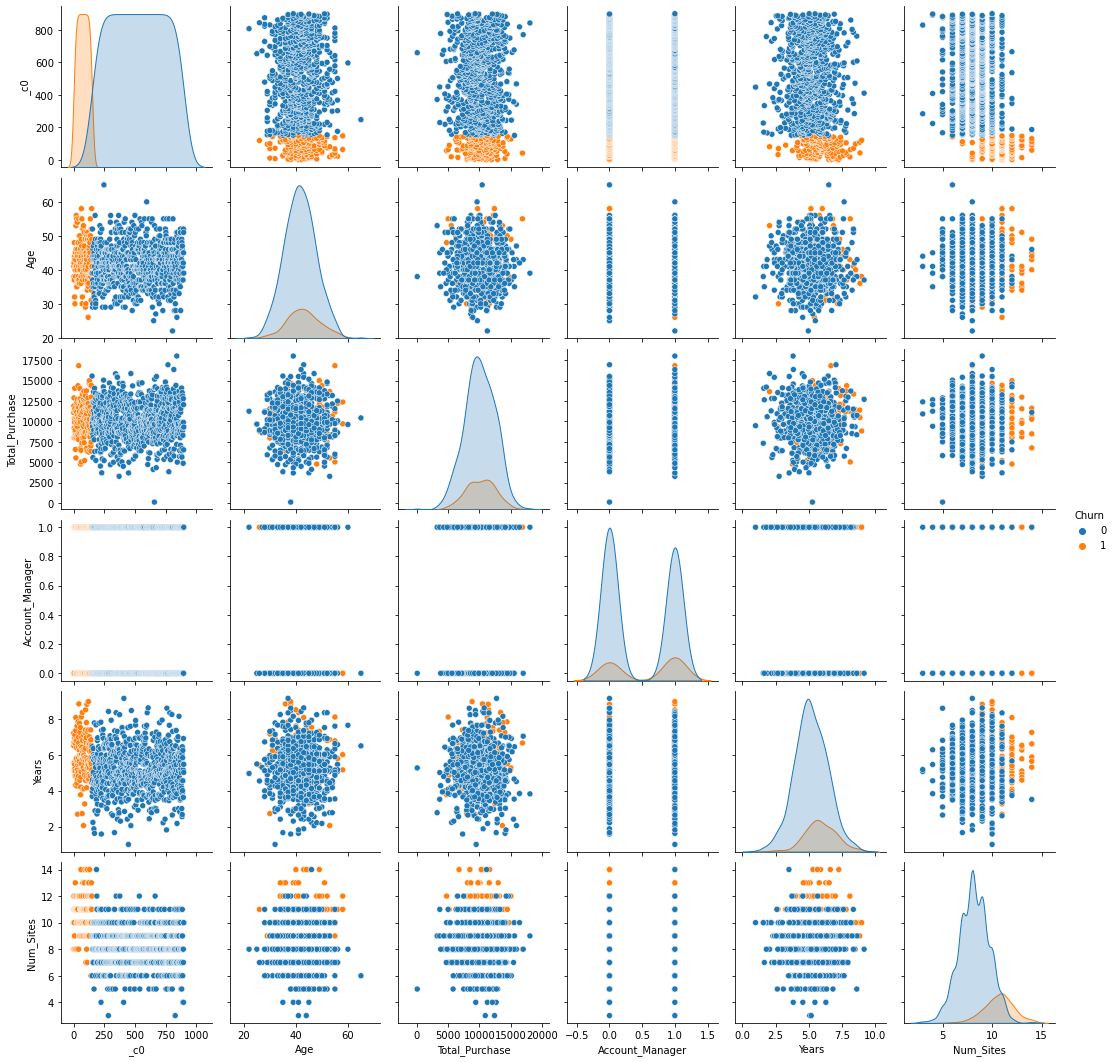

In [39]:
sns.pairplot(graphic_df,hue="Churn");

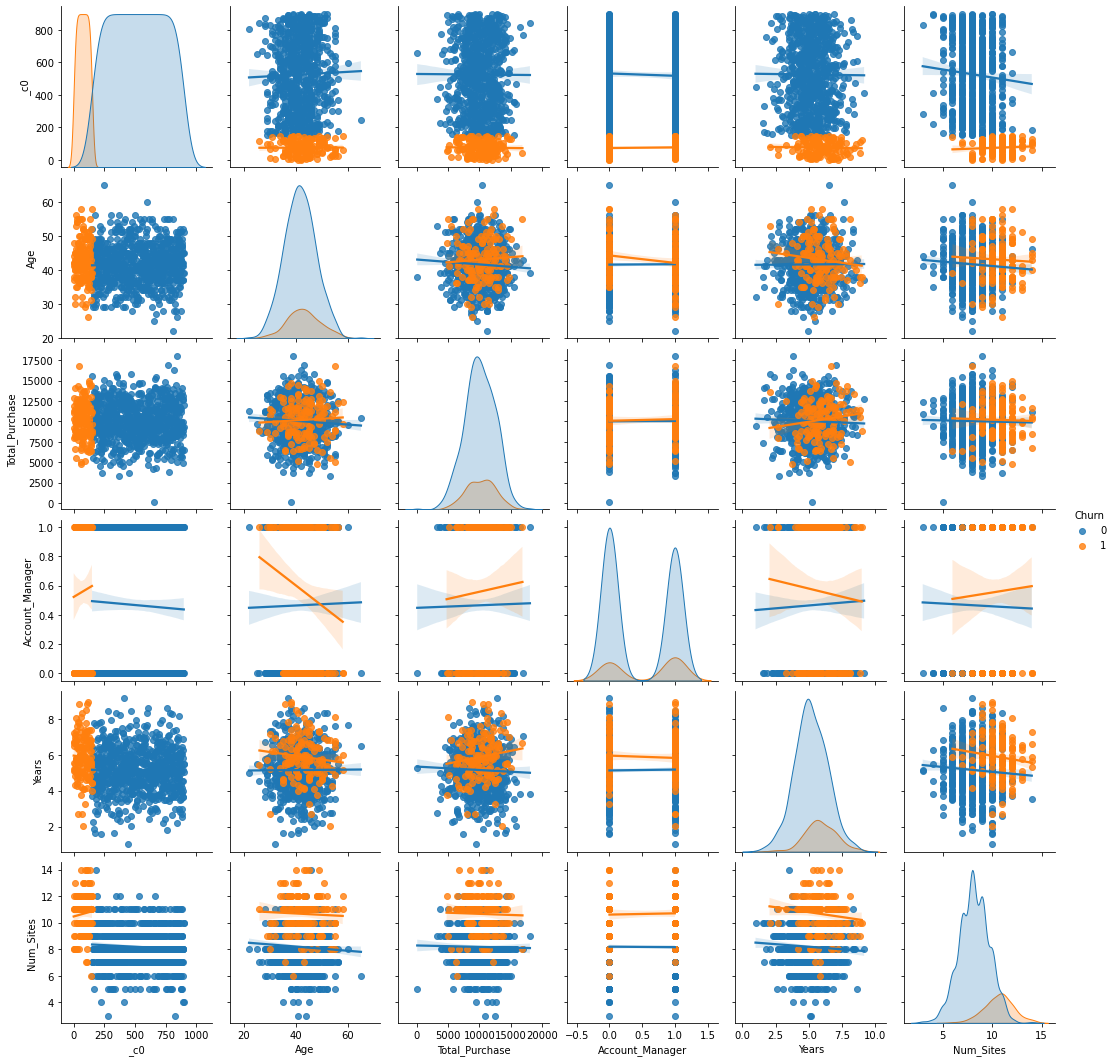

In [40]:
sns.pairplot(graphic_df,hue="Churn",kind="reg");

In [41]:
df=df.dropna()

In [43]:
df=df.withColumn("age_sqrt",df.Age**2)

In [44]:
df.show(10)

+---+----------------+----+--------------+---------------+-----+---------+-----+--------+
|_c0|           Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|Churn|age_sqrt|
+---+----------------+----+--------------+---------------+-----+---------+-----+--------+
|  0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|  1764.0|
|  1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|  1681.0|
|  2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|  1444.0|
|  3|   Phillip White|42.0|       8010.76|              0| 6.71|     10.0|    1|  1764.0|
|  4|  Cynthia Norton|37.0|       9191.58|              0| 5.56|      9.0|    1|  1369.0|
|  5|Jessica Williams|48.0|      10356.02|              0| 5.12|      8.0|    1|  2304.0|
|  6|     Eric Butler|44.0|      11331.58|              1| 5.23|     11.0|    1|  1936.0|
|  7|   Zachary Walsh|32.0|       9885.12|              1| 6.92|      9.0|    1|  1024.0|
|  8|     

In [47]:
stringIndexer=StringIndexer(inputCol="Churn",outputCol="label")

In [48]:
indexed=stringIndexer.fit(df).transform(df)

In [49]:
indexed.dtypes

[('_c0', 'int'),
 ('Names', 'string'),
 ('Age', 'double'),
 ('Total_Purchase', 'double'),
 ('Account_Manager', 'int'),
 ('Years', 'double'),
 ('Num_Sites', 'double'),
 ('Churn', 'int'),
 ('age_sqrt', 'double'),
 ('label', 'double')]

In [50]:
df=indexed.withColumn("label",indexed.label.cast("integer"))

In [52]:
df.dtypes

[('_c0', 'int'),
 ('Names', 'string'),
 ('Age', 'double'),
 ('Total_Purchase', 'double'),
 ('Account_Manager', 'int'),
 ('Years', 'double'),
 ('Num_Sites', 'double'),
 ('Churn', 'int'),
 ('age_sqrt', 'double'),
 ('label', 'int')]

In [59]:
free_val=['Age','Total_Purchase','Account_Manager','Years','Num_Sites']

In [60]:
vectorAssembler=VectorAssembler(inputCols=free_val,outputCol="features")

In [61]:
features_val=vectorAssembler.transform(df)

In [62]:
res_df=features_val.select("features","label")
res_df.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[42.0,11066.8,0.0...|    1|
|[41.0,11916.22,0....|    1|
|[38.0,12884.75,0....|    1|
|[42.0,8010.76,0.0...|    1|
|[37.0,9191.58,0.0...|    1|
|[48.0,10356.02,0....|    1|
|[44.0,11331.58,1....|    1|
|[32.0,9885.12,1.0...|    1|
|[43.0,14062.6,1.0...|    1|
|[40.0,8066.94,1.0...|    1|
|[30.0,11575.37,1....|    1|
|[45.0,8771.02,1.0...|    1|
|[45.0,8988.67,1.0...|    1|
|[40.0,8283.32,1.0...|    1|
|[41.0,6569.87,1.0...|    1|
|[38.0,10494.82,1....|    1|
|[45.0,8213.41,1.0...|    1|
|[43.0,11226.88,0....|    1|
|[53.0,5515.09,0.0...|    1|
|[46.0,8046.4,1.0,...|    1|
+--------------------+-----+
only showing top 20 rows



In [63]:
res_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = true)



In [64]:
splits=res_df.randomSplit([0.7,0.3])

In [65]:
train_df=splits[0]
test_df=splits[1]

In [66]:
train_df.count(),test_df.count()

(637, 263)

In [68]:
gbtc=GBTClassifier(maxIter=10,featuresCol="features",labelCol="label")

In [69]:
gbtc_model=gbtc.fit(train_df)

In [70]:
y_pred=gbtc_model.transform(test_df)

In [71]:
y_pred.show(10)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[22.0,11254.38,1....|    0|[1.11654103203467...|[0.90318120495220...|       0.0|
|[28.0,9090.43,1.0...|    0|[-0.9078154445062...|[0.13995895798370...|       1.0|
|[28.0,11245.38,0....|    0|[1.06549609070876...|[0.89387916265328...|       0.0|
|[29.0,9378.24,0.0...|    0|[1.11654103203467...|[0.90318120495220...|       0.0|
|[29.0,13240.01,1....|    0|[0.84131917355480...|[0.84325357577493...|       0.0|
|[29.0,13255.05,1....|    0|[0.84131917355480...|[0.84325357577493...|       0.0|
|[30.0,6744.87,0.0...|    0|[1.29835921385285...|[0.93065008440109...|       0.0|
|[30.0,7960.64,1.0...|    1|[1.24453626961602...|[0.92337220501867...|       0.0|
|[30.0,8677.28,1.0...|    0|[1.11546823633497...|[0.90299342152027...|       0.0|
|[30.0,10960.52,

In [72]:
ac=y_pred.select("label","prediction")
ac.show(10)

+-----+----------+
|label|prediction|
+-----+----------+
|    0|       0.0|
|    0|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    1|       0.0|
|    0|       0.0|
|    0|       1.0|
+-----+----------+
only showing top 10 rows



In [73]:
ac.filter(ac.label==ac.prediction).count()/ac.count()

0.8745247148288974

In [76]:
evaluator=BinaryClassificationEvaluator()
pramGrid=(ParamGridBuilder()
         .addGrid(gbtc.maxDepth,[2,4,6])
         .addGrid(gbtc.maxBins,[20,30])
         .addGrid(gbtc.maxIter,[10,20])
         .build())

cv=CrossValidator(estimator=gbtc,estimatorParamMaps=pramGrid,evaluator=evaluator,numFolds=10)

In [77]:
cv_model=cv.fit(train_df)
y_pred=cv_model.transform(test_df)

In [78]:
y_pred.show(10)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[22.0,11254.38,1....|    0|[1.42002511594884...|[0.94480208192471...|       0.0|
|[28.0,9090.43,1.0...|    0|[0.42795924870301...|[0.70180720672738...|       0.0|
|[28.0,11245.38,0....|    0|[1.01958030689498...|[0.88484776867546...|       0.0|
|[29.0,9378.24,0.0...|    0|[1.43077432070081...|[0.94591258579321...|       0.0|
|[29.0,13240.01,1....|    0|[1.42002511594884...|[0.94480208192471...|       0.0|
|[29.0,13255.05,1....|    0|[1.42002511594884...|[0.94480208192471...|       0.0|
|[30.0,6744.87,0.0...|    0|[0.99735701851686...|[0.88024096768574...|       0.0|
|[30.0,7960.64,1.0...|    1|[0.98191158772939...|[0.87694611243836...|       0.0|
|[30.0,8677.28,1.0...|    0|[1.00802824416472...|[0.88247262551913...|       0.0|
|[30.0,10960.52,

In [79]:
ac=y_pred.select("label","prediction")

In [80]:
ac.filter(ac.label==ac.prediction).count()/ac.count()

0.9125475285171103

In [81]:
evaluator.evaluate(y_pred)

0.8757518796992478